In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import folium
import os
from datetime import datetime, timedelta
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
print(os.getcwd())
%matplotlib inline

C:\Users\gijsd\Google Drive\Uni\AT year 3\M12 Bachelor Assignment\thesis_code


In [10]:
#fileName = 'experiment_data/dimension_axis_test/Align_Axis_Test_16-05-2023 15-52-13.335' #read in filename, remove '_phone.csv'
#fileName = 'experiment_data/06/06_r_10_0_24-05-2023 14-30-15.743'
#fileName = 'data/on_campus_tests/TestOldHolder_15-05-2023 10-12-56.980'
fileName = 'experiment_data/10/10_c_10_1_01-06-2023 14-13-16.253'
df_phone = pd.read_csv(fileName + "_phone.csv", header=None)
df_gps = pd.read_csv(fileName + "_gps.csv", header=None)
df_thingy = pd.read_csv(fileName + "_thingy.csv", header=None)
df_phone.columns = ['timeStamp',
                    'mAcc_0','mAcc_1','mAcc_2', # Phone acc is in m/s^2 according to android studio
                    'mAcc_cal_0','mAcc_cal_1','mAcc_cal_2', #calibrated phone accelerometer
                    'mGyr_0','mGyr_1','mGyr_2']
df_gps.columns = [
    'timeStamp',
    'currentSpeed','distance',
    'mLocationLat','mLocationLong',
]
df_thingy.columns = [
    'timeStamp',
    'xa','ya','za',
    'xa_cal','ya_cal','za_cal', # Calibrated Thingy:52 accelerometer
    'xg','yg','zg'
]

def processDataFrame(df):
    df['timeStamp'] = df['timeStamp'].apply(lambda x: datetime.strptime(x, '%H:%M:%S.%f'))
    start_time = df['timeStamp'].iloc[0]
    df['Time (s)'] = (df['timeStamp'] - start_time).dt.total_seconds()
    total_time = df['Time (s)'].iloc[-1]
    fs = len(df)/total_time # Sampling frequency of Thingy, should be 200 Hz
    #print("Total elapsed time: {:.2f} seconds".format(total_time))

    #P1 configuration, align coordinates of phone to thingy, dimension sync
    if "mAcc_0" in df.columns: #Phone df
        #Acc: Z = -Z, X = -Y and Y = -X
        df['mAcc_2'], df['mAcc_cal_2'], df['mAcc_0'],  df['mAcc_cal_0'], df['mAcc_1'], df['mAcc_cal_1'] = df['mAcc_2'], df['mAcc_cal_2'], -df['mAcc_1'],  -df['mAcc_cal_1'], df['mAcc_0'], -df['mAcc_cal_0']

        #Gyr: Z = -Z, Y = X, X = Y
        df['mGyr_0'], df['mGyr_1'], df['mGyr_2'] = df['mGyr_1'], df['mGyr_0'], -df['mGyr_2']

    # Get datetime where 'Time (s)' = 1 and 2
    t_interval_start = 0
    t_interval_end = 1000

    idx1 = (df['Time (s)'] - t_interval_start).abs().idxmin()
    idx2 = (df['Time (s)'] - t_interval_end).abs().idxmin()
    dt1 = df.loc[idx1, 'timeStamp']
    dt2 = df.loc[idx2, 'timeStamp']
    df = df.loc[(df['timeStamp'] >= dt1) & (df['timeStamp'] <= dt2)]

    return fs, df

fs_phone, df_phone = processDataFrame(df_phone)
fs_gps, df_gps = processDataFrame(df_gps)
fs_thingy, df_thingy = processDataFrame(df_thingy)

print(f'fs_phone = {fs_phone} Hz\nfs_gps = {fs_gps} Hz\nfs_thingy = {fs_thingy} Hz')

print(df_phone)

fs_phone = 514.4817501827794 Hz
fs_gps = 1.0747822151827129 Hz
fs_thingy = 192.51126126126124 Hz
                   timeStamp    mAcc_0    mAcc_1     mAcc_2  mAcc_cal_0  \
0    1900-01-01 14:13:16.255       NaN       NaN        NaN         NaN   
1    1900-01-01 14:13:16.255  2.846562  1.671088   6.262914    3.536949   
2    1900-01-01 14:13:16.258       NaN       NaN        NaN         NaN   
3    1900-01-01 14:13:16.258  2.305484  1.146760   4.666004    2.995872   
4    1900-01-01 14:13:16.259       NaN       NaN        NaN         NaN   
...                      ...       ...       ...        ...         ...   
9143 1900-01-01 14:13:34.030       NaN       NaN        NaN         NaN   
9144 1900-01-01 14:13:34.030 -1.905584  0.754038  11.283355   -1.215197   
9145 1900-01-01 14:13:34.030       NaN       NaN        NaN         NaN   
9146 1900-01-01 14:13:34.036 -3.598207  2.640779   9.075976   -2.907820   
9147 1900-01-01 14:13:34.036       NaN       NaN        NaN         NaN   

  

Sample frequency of mAcc = 207.24368708171644 Hz
Sample frequency of mGyr = 207.24368708171644 Hz


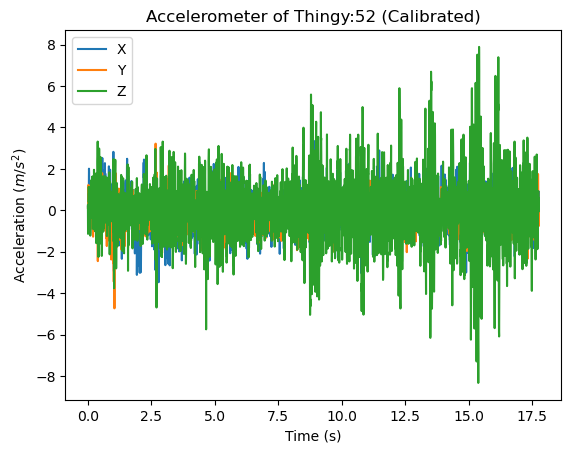

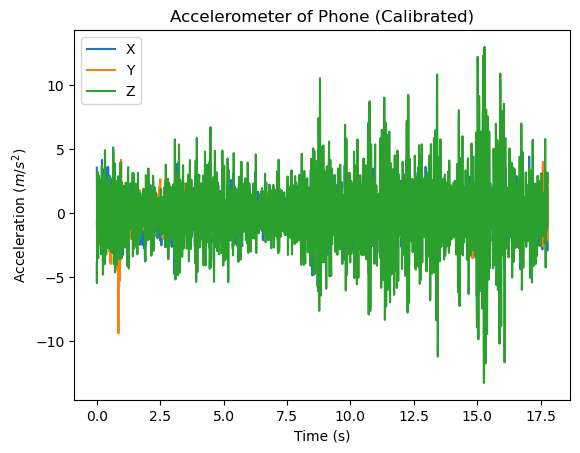

In [11]:
acc = df_thingy.dropna(subset = ['xa','ya','za','xa_cal','ya_cal','za_cal'])[['Time (s)','timeStamp','xa','ya','za','xa_cal','ya_cal','za_cal']]
gyr = df_thingy.dropna(subset = ['xg','yg','zg'])[['Time (s)','timeStamp','xg','yg','zg']]
mAcc = df_phone.dropna(subset=['mAcc_0','mAcc_1','mAcc_2','mAcc_cal_0','mAcc_cal_1','mAcc_cal_2'])[['Time (s)','timeStamp', 'mAcc_0','mAcc_1','mAcc_2','mAcc_cal_0','mAcc_cal_1','mAcc_cal_2']]
mGyr = df_phone.dropna(subset=['mGyr_0','mGyr_1','mGyr_2'])[['Time (s)','timeStamp', 'mGyr_0','mGyr_1','mGyr_2']]
mAcc = mAcc.reset_index(drop=True)
mGyr = mGyr.reset_index(drop=True)
acc = acc.reset_index(drop=True)
gyr = gyr.reset_index(drop=True)

# Change to thingy acceleration to m/s^2
gravity_fac = 9.81
acc.iloc[:, 2:] = acc.iloc[:, 2:].multiply(gravity_fac)

# Sampling frequency
fs_phone_acc = len(mAcc)/(mAcc['Time (s)'].iloc[-1] - mAcc['Time (s)'].iloc[0])
fs_phone_gyr = len(mGyr)/(mGyr['Time (s)'].iloc[-1] - mGyr['Time (s)'].iloc[0])
print(f'Sample frequency of mAcc = {fs_phone_acc} Hz\nSample frequency of mGyr = {fs_phone_gyr} Hz')

acc_time = np.arange(len(acc)) / fs_thingy
#acc_time = acc['Time (s)']
plt.plot(acc_time, acc['xa_cal'], label='X')
plt.plot(acc_time, acc['ya_cal'], label='Y')
plt.plot(acc_time, acc['za_cal'], label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Acceleration ($m/s^2$)'), plt.title('Accelerometer of Thingy:52 (Calibrated)'), plt.legend(loc='best')
plt.show()

#mAccTime = np.arange(len(mAcc)) / fs_phone_acc
mAccTime = mAcc['Time (s)']
fs_phone_acc = len(mAcc)/(mAcc['Time (s)'].iloc[-1] - mAcc['Time (s)'].iloc[0])
plt.plot(mAccTime, mAcc['mAcc_cal_0'], label='X')
plt.plot(mAccTime, mAcc['mAcc_cal_1'], label='Y')
plt.plot(mAccTime, mAcc['mAcc_cal_2'], label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Acceleration ($m/s^2$)'), plt.title('Accelerometer of Phone (Calibrated)'), plt.legend(loc='best')
plt.show()

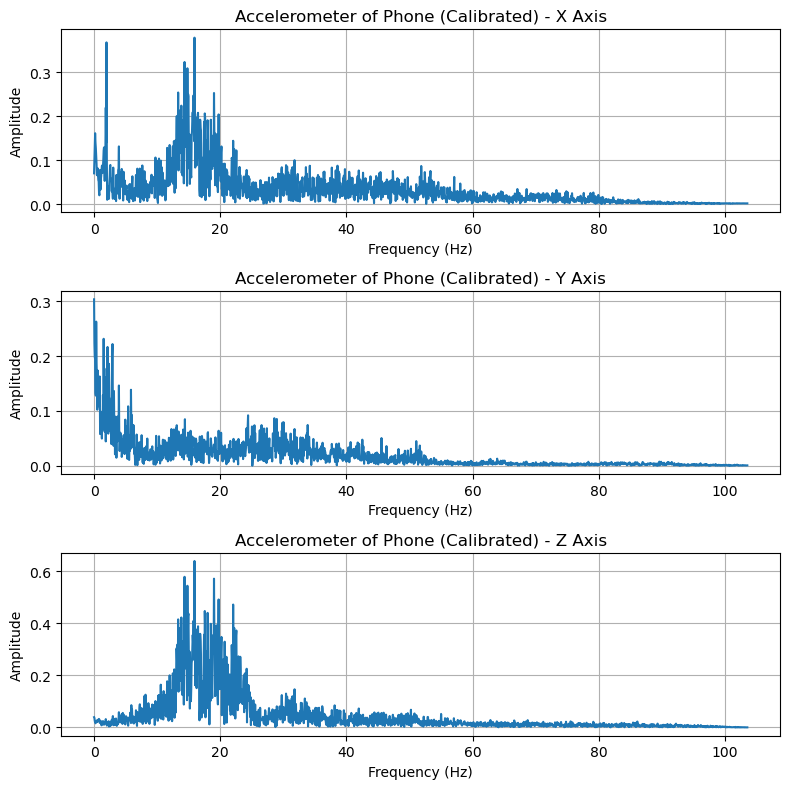

In [12]:
# Perform Fourier transform on X, Y, Z axes
N = len(mAcc) # Number of data points
xf = fftfreq(N, 1/fs_phone_acc)[:N//2]  # Frequency axis (positive frequencies only)
yf_x = fft(mAcc['mAcc_cal_0'].to_numpy())
yf_y = fft(mAcc['mAcc_cal_1'].to_numpy())
yf_z = fft(mAcc['mAcc_cal_2'].to_numpy())

# Plot frequency spectrum for X, Y, Z axes
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(xf, 2.0/N * np.abs(yf_x[:N//2]))
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Accelerometer of Phone (Calibrated) - X Axis')

axs[1].plot(xf, 2.0/N * np.abs(yf_y[:N//2]))
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Accelerometer of Phone (Calibrated) - Y Axis')

axs[2].plot(xf, 2.0/N * np.abs(yf_z[:N//2]))
axs[2].set_ylabel('Amplitude')
axs[2].set_title('Accelerometer of Phone (Calibrated) - Z Axis')

for ax in axs:
    ax.set_xlabel('Frequency (Hz)')
    ax.grid(True)

plt.tight_layout()
plt.show()

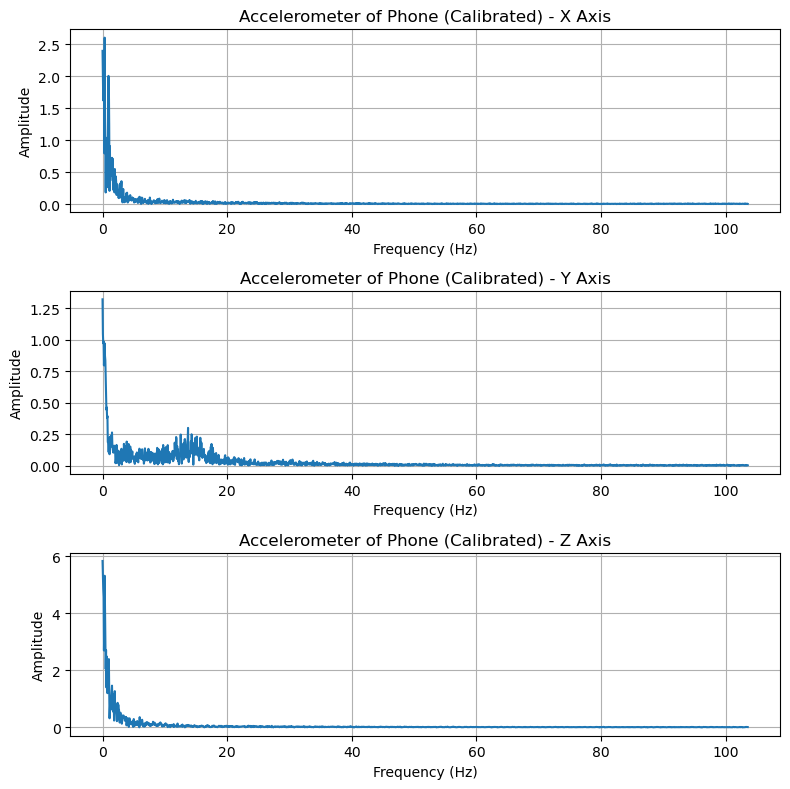

In [15]:
# Perform Fourier transform on X, Y, Z axes
N = len(mAcc)  # Number of data points
xf = fftfreq(N, 1 / fs_phone_acc)[:N // 2]  # Frequency axis (positive frequencies only)
yf_x = fft(acc['xa_cal'].to_numpy())
yf_y = fft(acc['ya_cal'].to_numpy())
yf_z = fft(acc['za_cal'].to_numpy())

# Plot frequency spectrum for X, Y, Z axes
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(xf, 2.0 / N * np.abs(yf_x[:N // 2]))
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Accelerometer of Phone (Calibrated) - X Axis')

axs[1].plot(xf, 2.0 / N * np.abs(yf_y[:N // 2]))
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Accelerometer of Phone (Calibrated) - Y Axis')

axs[2].plot(xf, 2.0 / N * np.abs(yf_z[:N // 2]))
axs[2].set_ylabel('Amplitude')
axs[2].set_title('Accelerometer of Phone (Calibrated) - Z Axis')

for ax in axs:
    ax.set_xlabel('Frequency (Hz)')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Define filter parameters
order = 4
cutoff_freq = 10 # Hz

# Normalize cutoff frequency
nyquist_freq = 0.5 * fs_phone_acc
cutoff_norm = cutoff_freq / nyquist_freq

# Define filter coefficients using Butterworth filter design
b, a, _ = butter(order, cutoff_norm, btype='lowpass')

# Apply filter to X-axis accelerometer data
mAcc_filt_0 = filtfilt(b, a, mAcc['mAcc_cal_0'])
mAcc_filt_1 = filtfilt(b, a, mAcc['mAcc_cal_1'])
mAcc_filt_2 = filtfilt(b, a, mAcc['mAcc_cal_2'])

# Plot filtered data
plt.plot(mAccTime, mAcc['mAcc_cal_0'], label='X')
plt.plot(mAccTime, mAcc_filt_0, label='X (Filtered)')
plt.xlabel('Time (s)'), plt.ylabel('Acceleration ($m/s^2$)'), plt.title('Filtered X Accelerometer of Phone (Calibrated)'), plt.legend(loc='best')
plt.show()

plt.plot(mAccTime, mAcc['mAcc_cal_1'], label='Y')
plt.plot(mAccTime, mAcc_filt_1, label='Y (Filtered)')
plt.xlabel('Time (s)'), plt.ylabel('Acceleration ($m/s^2$)'), plt.title('Filtered Y Accelerometer of Phone (Calibrated)'), plt.legend(loc='best')
plt.show()

plt.plot(mAccTime, mAcc['mAcc_cal_2'], label='Z')
plt.plot(mAccTime, mAcc_filt_2, label='Z (Filtered)')
plt.xlabel('Time (s)'), plt.ylabel('Acceleration ($m/s^2$)'), plt.title('Filtered Z Accelerometer of Phone (Calibrated)'), plt.legend(loc='best')
plt.show()

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
gyr_x = gyr['xg']
gyr_y = gyr['yg']
gyr_z = gyr['zg']
phone_gyr_x = mGyr['mGyr_0'] * 180 / math.pi
phone_gyr_y = mGyr['mGyr_1'] * 180 / math.pi
phone_gyr_z = mGyr['mGyr_2'] * 180 / math.pi

#Thingy gyroscope
gyr_time = np.arange(len(gyr)) / fs_thingy
#gyr_time = df_thingy['Time (s)']
plt.plot(gyr_time,gyr_x, label='X')
plt.plot(gyr_time,gyr_y, label='Y')
plt.plot(gyr_time,gyr_z, label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Angular velocity (deg/s)'), plt.title('Gyroscope of Thingy:52'), plt.legend(loc='best')
plt.show()

#Phone gyroscope
#mGyrTime = np.arange(len(mGyr)) / fs_phone_gyr
mGyrTime = mGyr['Time (s)']
plt.plot(mGyrTime, phone_gyr_x, label='X')
plt.plot(mGyrTime, phone_gyr_y, label='Y')
plt.plot(mGyrTime, phone_gyr_z, label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Angular velocity (deg/s)'), plt.title('Gyroscope of Phone'),plt.legend(loc='best')
plt.show()

#TODO: FOURIER TRANSFORM AND SEE WHAT IS NOISE, filter out noise -> to find out whether i can use this positioning

In [ ]:
phone_gyr_x_filt = filtfilt(b, a, phone_gyr_x)
phone_gyr_y_filt = filtfilt(b, a, phone_gyr_y)
phone_gyr_z_filt = filtfilt(b, a, phone_gyr_z)

plt.plot(mGyrTime, phone_gyr_x_filt, label='X')
plt.plot(mGyrTime, phone_gyr_y_filt, label='Y')
plt.plot(mGyrTime, phone_gyr_z_filt, label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Angular velocity (deg/s)'), plt.title('Gyroscope of Phone Filtered'),plt.legend(loc='best')
plt.show()

In [ ]:
# Compute the cumulative sum of the gyroscope data for each dimension to get the angle
angle_x = np.cumsum(gyr_x)*(1/fs_thingy)
angle_y = np.cumsum(gyr_y)*(1/fs_thingy)
angle_z = np.cumsum(gyr_z)*(1/fs_thingy)
phone_angle_x = np.cumsum(phone_gyr_x_filt) * (1 / fs_phone_gyr) #phone angle x
phone_angle_y = np.cumsum(phone_gyr_y_filt) * (1 / fs_phone_gyr)
phone_angle_z = np.cumsum(phone_gyr_z_filt) * (1 / fs_phone_gyr)

# Find the index of the last point that crosses the time-axis
crossings = (angle_z.shift(1) >= 0) != (angle_z >= 0)
last_crossing_time = gyr.loc[crossings[::-1].idxmax(), 'Time (s)']
plt.axvline(x=last_crossing_time, linestyle='--', color='k', label='$t_m$')
print(f't_m for this maneuver: {last_crossing_time}')

# Plot the Thingy:52 angles
plt.plot(gyr_time, angle_x, label='X')# Tilt of bike
plt.plot(gyr_time, angle_y, label='Y')# Driving up and downhill
plt.plot(gyr_time, angle_z, label='Z')# Direction of bike
plt.xlabel('Time (s)'), plt.ylabel('Angle (deg)'), plt.title('Angle of Thingy:52'), plt.legend(loc='best')
plt.show()

# Plot the phone angles
plt.plot(mGyrTime, phone_angle_x, label='X')
plt.plot(mGyrTime, phone_angle_y, label='Y')
plt.plot(mGyrTime, phone_angle_z, label='Z')
plt.xlabel('Time (s)'), plt.ylabel('Angle (deg)'), plt.title('Angle of Phone'), plt.legend(loc='best')
plt.show()

In [ ]:
plt.plot(gyr['timeStamp'],gyr_z,label="Thingy Z")
plt.plot(mGyr['timeStamp'],phone_gyr_z,label="Phone Z")
plt.legend()
plt.show()

In [ ]:
min_phone_z = min(phone_gyr_z)
min_thingy_z = min(gyr_z)

index_phone_z = phone_gyr_z.tolist().index(min_phone_z)
index_thingy_z = gyr_z.tolist().index(min_thingy_z)

phone_z_peak_timestamp = mGyr['timeStamp'][index_phone_z]
thingy_z_peak_timestamp = gyr['timeStamp'][index_thingy_z]

timestamp_difference = (thingy_z_peak_timestamp - phone_z_peak_timestamp).total_seconds() * 1000
print(timestamp_difference)

#Time_difference seems like 166 ms
gyr['timeStamp'] = [timestamp - timedelta(milliseconds=200) for timestamp in gyr['timeStamp']]

plt.plot(gyr['timeStamp'],gyr_z,label="Thingy Z")
plt.plot(mGyr['timeStamp'],phone_gyr_z,label="Phone Z")
plt.legend()
plt.show()

In [ ]:
plt.plot(acc['timeStamp'],acc['za_cal'],label="Thingy Z")
plt.plot(mAcc['timeStamp'],mAcc['mAcc_cal_2'],label="Phone Z")
plt.legend()
plt.show()

In [ ]:
%matplotlib qt
# -> qt or inline
# Create a figure object with 2 subplots for Thingy gyroscope

def plotGyr(name, time, _gyr_x,_gyr_y,_gyr_z,_angle_x,_angle_y,_angle_z):
    fig1, axs1 = plt.subplots(1, 2, figsize=(15, 8))
    axs1[0].plot(time, _gyr_x, label='X', linewidth=2)
    axs1[0].plot(time, _gyr_y, label='Y', linewidth=2)
    axs1[0].plot(time, _gyr_z, label='Z', linewidth=2)
    axs1[0].axvline(x=last_crossing_time, linestyle='--', color='k', label='$t_m$')
    axs1[0].set_xlabel('Time (s)', fontsize=16), axs1[0].set_ylabel('Angular Velocity (deg/s)', fontsize=16), axs1[0].set_title(name + ': Raw Gyroscope Of ...', fontsize=18), axs1[0].legend(loc='best', fontsize=14)
    axs1[0].tick_params(axis='both', which='major', labelsize=15)
    axs1[1].plot(time, _angle_x, label='X', linewidth=2) # Tilt of bike
    axs1[1].plot(time, _angle_y, label='Y', linewidth=2) # Driving up and downhill
    axs1[1].plot(time, _angle_z, label='Z', linewidth=2) # Direction of bike
    axs1[1].axvline(x=last_crossing_time, linestyle='--', color='k', label='$t_m$')
    axs1[1].set_xlabel('Time (s)', fontsize=16), axs1[1].set_ylabel('Angle (deg)', fontsize=16), axs1[1].set_title(name + ': Angle Of ...', fontsize=18), axs1[1].legend(loc='best', fontsize=14)
    axs1[1].tick_params(axis='both', which='major', labelsize=15)
    plt.show()


plotGyr("Thingy",gyr_time, gyr_x,gyr_y,gyr_z,angle_x,angle_y,angle_z)

plotGyr("Phone",mGyrTime, phone_gyr_x, phone_gyr_y,phone_gyr_z, phone_angle_x, phone_angle_y, phone_angle_z)